# EDA of NYC MTA Turnstile 

## by Yoga Pratama

## Data Information
Collected from http://web.mta.info/developers/turnstile.html <br>

Field description: <br>
C/A      = Control Area (A002) <br>
UNIT     = Remote Unit for a station (R051) <br>
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00) <br>
STATION  = Represents the station name the device is located at <br>
LINENAME = Represents all train lines that can be boarded at this station
           Normally lines are represented by one character. <br> 
DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND  <br>
DATE     = Represents the date (MM-DD-YY) <br>
TIME     = Represents the time (hh:mm:ss) for a scheduled audit event <br>
DESC     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities.
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered.
ENTRIES  = The comulative entry register value for a device<br>
EXIST    = The cumulative exit register value for a device

# Data Preprocessing

In [1]:
#Import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from collections import defaultdict
pd.options.display.float_format = '{:.2f}'.format

In [2]:
#read from web (prioritise on June)
june = [180602, 180609, 180616, 180623, 180630]
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
df_list = []
for week in june:
    df_list.append(pd.read_csv(url.format(week)))
df_mta = pd.concat(df_list)

In [3]:
df_mta.dtypes

C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                  int64
EXITS                                                                    int64
dtype: object

In [4]:
print (df_mta.shape)

(983733, 11)


In [5]:
#Glimpse of the dataset, this dataset already subsetted to June 2018
df_mta.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,00:00:00,REGULAR,6633898,2248498
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,04:00:00,REGULAR,6633916,2248500
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,08:00:00,REGULAR,6633928,2248517
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,12:00:00,REGULAR,6634015,2248577
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,16:00:00,REGULAR,6634173,2248610
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,20:00:00,REGULAR,6634367,2248645
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2018,00:00:00,REGULAR,6634496,2248662
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2018,04:00:00,REGULAR,6634503,2248664
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2018,08:00:00,REGULAR,6634514,2248675
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2018,12:00:00,REGULAR,6634542,2248713


In [6]:
df_mta.tail(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
196680,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/28/2018,09:00:00,REGULAR,2953544,387653
196681,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/28/2018,13:00:00,REGULAR,2953874,387654
196682,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/28/2018,17:00:00,REGULAR,2954306,387664
196683,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/28/2018,21:00:00,REGULAR,2954587,387672
196684,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,01:00:00,REGULAR,2954726,387680
196685,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,05:00:00,REGULAR,2954731,387681
196686,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,09:00:00,REGULAR,2954991,387686
196687,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,13:00:00,REGULAR,2955443,387690
196688,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,17:00:00,REGULAR,2955940,387696
196689,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,21:00:00,REGULAR,2956334,387720


In [7]:
#Count number of people entry on each day
temp_d = defaultdict(list)
turnstile_d = {}
for row in df_mta.itertuples():
    C_A, unit, scp, station, linename, date = row[1], row[2], row[3], row[4], ''.join(sorted(row[5])), row[7]
    entries = row[10]
    k = (C_A, unit, scp, station, linename, date)
    temp_d[k].append(entries)
    
for key, value in temp_d.items():
    entry = abs(max(value) - min(value))
    turnstile_d[key] = [entry]

In [8]:
#Create an entry data frame
dict_df_entry = pd.DataFrame.from_dict(turnstile_d, orient='index')
dict_df_entry.rename(columns = {0:'Entries'}, inplace=True)
dict_df_entry.head(10)

,Entries
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/26/2018)",469
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/27/2018)",360
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/28/2018)",450
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/29/2018)",1154
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/30/2018)",1244
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/31/2018)",1297
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 06/01/2018)",1292
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/26/2018)",411
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/27/2018)",308
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/28/2018)",406


In [9]:
#Count number of people exits on each day
temp_d = defaultdict(list)
turnstile_d = {}
for row in df_mta.itertuples():
    C_A, unit, scp, station, linename, date = row[1], row[2], row[3], row[4], ''.join(sorted(row[5])), row[7]
    exits = row[11]
    k = (C_A, unit, scp, station, linename, date)
    temp_d[k].append(exits)
    
for key, value in temp_d.items():
    exits = abs(max(value) - min(value))
    turnstile_d[key] = [exits]

In [10]:
#Create an exit data frame
dict_df_exits = pd.DataFrame.from_dict(turnstile_d, orient='index')
dict_df_exits.rename(columns = {0:'Exits'}, inplace=True)
dict_df_exits.head(10)

,Exits
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/26/2018)",147
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/27/2018)",114
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/28/2018)",143
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/29/2018)",526
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/30/2018)",553
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/31/2018)",521
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 06/01/2018)",516
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/26/2018)",81
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/27/2018)",68
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/28/2018)",94


In [11]:
#Split the df and give them column name
df_turnstile = pd.DataFrame(columns=[])
df_turnstile['C/A'] = [row[0][0] for row in dict_df_exits.itertuples()]
df_turnstile['Unit'] = [row[0][1] for row in dict_df_exits.itertuples()]
df_turnstile['SCP'] = [row[0][2] for row in dict_df_exits.itertuples()]
df_turnstile['Station'] = [row[0][3] for row in dict_df_exits.itertuples()]
df_turnstile['Linename'] = [row[0][4] for row in dict_df_exits.itertuples()]
df_turnstile['Date'] = [row[0][5] for row in dict_df_exits.itertuples()]
df_turnstile['Entries'] = [row[1] for row in dict_df_entry.itertuples()]
df_turnstile['Exits'] = [row[1] for row in dict_df_exits.itertuples()]

In [12]:
#Count the number of entries and exits for each day
#keep column needed for exploration
df_turnstile.head(10)

,C/A,Unit,SCP,Station,Linename,Date,Entries,Exits
0,A002,R051,02-00-00,59 ST,456NQRW,05/26/2018,469,147
1,A002,R051,02-00-00,59 ST,456NQRW,05/27/2018,360,114
2,A002,R051,02-00-00,59 ST,456NQRW,05/28/2018,450,143
3,A002,R051,02-00-00,59 ST,456NQRW,05/29/2018,1154,526
4,A002,R051,02-00-00,59 ST,456NQRW,05/30/2018,1244,553
5,A002,R051,02-00-00,59 ST,456NQRW,05/31/2018,1297,521
6,A002,R051,02-00-00,59 ST,456NQRW,06/01/2018,1292,516
7,A002,R051,02-00-01,59 ST,456NQRW,05/26/2018,411,81
8,A002,R051,02-00-01,59 ST,456NQRW,05/27/2018,308,68
9,A002,R051,02-00-01,59 ST,456NQRW,05/28/2018,406,94


In [13]:
df_turnstile.shape

(164362, 8)

In [134]:
#Count how many unit and station for each linename
df_linename_count = df_turnstile.groupby('Linename').nunique().sort_values(by=['Station'], ascending=False)
df_linename_count = df_linename_count[['Station', 'Unit']]
df_linename_count.reset_index(inplace=True)
df_linename_count

,Linename,Station,Unit
0,1,48,43
1,6,31,31
2,25,25,25
3,A,21,22
4,F,21,21
...,...,...,...
90,ACS,1,1
91,BDE,1,1
92,BDFM,1,1
93,BDFMNQRW,1,2


In [132]:
#Count how many unit and linename for each station
df_station_count = df_turnstile.groupby('Station').nunique().sort_values(by=['Unit'], ascending=False)
df_station_count = df_station_count[['Unit', 'Linename']]
df_station_count.reset_index(inplace=True)
df_station_count

,Station,Unit,Linename
0,23 ST,6,5
1,CANAL ST,5,3
2,86 ST,5,5
3,GRD CNTRL-42 ST,4,1
4,34 ST-PENN STA,4,3
...,...,...,...
372,BEACH 105 ST,1,1
373,BAYCHESTER AV,1,1
374,BAY RIDGE-95 ST,1,1
375,BAY RIDGE AV,1,1


In [14]:
# detecting outliers
df_turnstile.describe()

,Entries,Exits
count,164362.00,164362.00
mean,83124.58,66845.52
std,10973003.00,9203784.69
min,0.00,0.00
25%,237.00,130.00
50%,732.00,445.00
75%,1431.00,1007.00
max,2113959893.00,1838305870.00


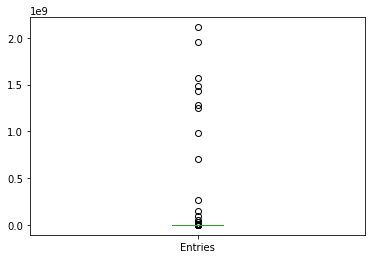

In [15]:
df_turnstile['Entries'].plot(kind = 'box')

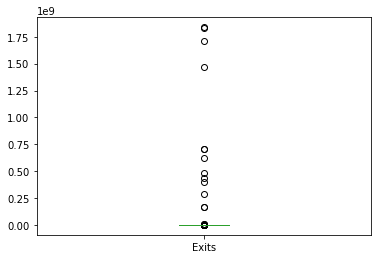

In [16]:
df_turnstile['Exits'].plot(kind = 'box')

In [17]:
#CLean outlier using IQR methods
Q1 = df_turnstile.quantile(0.25)
Q3 = df_turnstile.quantile(0.75)
IQR = Q3 - Q1
lower_range = Q1 - (1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)
print(IQR)
print(lower_range)
print(upper_range)

Entries   1194.00
Exits      877.00
dtype: float64
Entries   -1554.00
Exits     -1185.50
dtype: float64
Entries   3222.00
Exits     2322.50
dtype: float64


In [18]:
#Check the location of outlier in Entries
df_turnstile [(df_turnstile.Entries > upper_range.Entries)]

,C/A,Unit,SCP,Station,Linename,Date,Entries,Exits
230,A010,R080,00-00-06,57 ST-7 AV,NQRW,06/01/2018,3277,583
231,A010,R080,00-00-07,57 ST-7 AV,NQRW,05/26/2018,3528,705
234,A010,R080,00-00-07,57 ST-7 AV,NQRW,05/29/2018,4962,605
235,A010,R080,00-00-07,57 ST-7 AV,NQRW,05/30/2018,5009,640
236,A010,R080,00-00-07,57 ST-7 AV,NQRW,05/31/2018,4992,599
...,...,...,...,...,...,...,...,...
162530,R602,R108,00-06-01,BOROUGH HALL,2345R,06/25/2018,4196,205
162531,R602,R108,00-06-01,BOROUGH HALL,2345R,06/26/2018,4309,195
162532,R602,R108,00-06-01,BOROUGH HALL,2345R,06/27/2018,4369,173
162533,R602,R108,00-06-01,BOROUGH HALL,2345R,06/28/2018,3996,205


In [19]:
#Check the location of outlier in Exits
df_turnstile [(df_turnstile.Exits > upper_range.Exits)]

,C/A,Unit,SCP,Station,Linename,Date,Entries,Exits
87,A006,R079,00-00-00,5 AV/59 ST,NQRW,05/29/2018,1489,2735
88,A006,R079,00-00-00,5 AV/59 ST,NQRW,05/30/2018,1503,3120
89,A006,R079,00-00-00,5 AV/59 ST,NQRW,05/31/2018,1581,3085
90,A006,R079,00-00-00,5 AV/59 ST,NQRW,06/01/2018,1457,2948
238,A011,R080,01-00-00,57 ST-7 AV,NQRW,05/26/2018,227,3138
...,...,...,...,...,...,...,...,...
163302,R626,R062,00-00-04,CROWN HTS-UTICA,34,06/27/2018,1194,3324
163303,R626,R062,00-00-04,CROWN HTS-UTICA,34,06/28/2018,1179,3083
163304,R626,R062,00-00-04,CROWN HTS-UTICA,34,06/29/2018,1077,2947
163391,R628,R064,00-00-00,SARATOGA AV,3,06/25/2018,896,2392


In [20]:
#Using IQR method to clean the data frame
#Check the cleaned dataframe
df_turnstile_cln = df_turnstile[~((df_turnstile < (Q1 - 1.5 * IQR)) |(df_turnstile > (Q3 + 1.5 * IQR))).any(axis=1)]
print (df_turnstile_cln.describe())
print (df_turnstile_cln.shape)

        Entries     Exits
count 151460.00 151460.00
mean     843.14    562.20
std      760.62    559.63
min        0.00      0.00
25%      200.00    107.00
50%      665.00    389.00
75%     1302.00    855.00
max     3222.00   2322.00
(151460, 8)


In [21]:
#Change the format of Date and Time to datetime
df_turnstile_cln['Date'] = pd.to_datetime(df_turnstile_cln.loc[:, 'Date'], format = '%m/%d/%Y')
print (df_turnstile_cln.dtypes)

C/A                 object
Unit                object
SCP                 object
Station             object
Linename            object
Date        datetime64[ns]
Entries              int64
Exits                int64
dtype: object


C:\Users\Yoga Pratama S\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Checking faulty machine frequency

In [22]:
#Check for faulty machine that create impossible value

df_turnstile [(df_turnstile.Entries > 10000)]

,C/A,Unit,SCP,Station,Linename,Date,Entries,Exits
2142,A084,R125,01-00-00,BROAD ST,JZ,05/26/2018,4111415,63391
7145,N013,R035,02-00-01,168 ST,1AC,05/31/2018,4709085,3592721
10301,N117,R198,01-00-01,NOSTRAND AV,AC,05/30/2018,11178569,12363153
18651,PTH03,R552,00-01-04,JOURNAL SQUARE,1,05/29/2018,133054,91676
18910,PTH05,R543,00-01-02,EXCHANGE PLACE,1,05/29/2018,44326,112655
...,...,...,...,...,...,...,...,...
150903,PTH13,R541,00-04-04,THIRTY ST,1,06/25/2018,191683,15345
151155,PTH17,R541,01-00-07,THIRTY THIRD ST,1,06/27/2018,23908,21234
151701,PTH22,R540,00-01-00,PATH NEW WTC,1,06/27/2018,14694,4154
155836,R210,R044,00-03-03,BROOKLYN BRIDGE,456JZ,06/25/2018,683090,468945


In [23]:
#Check the location of outlier in Exits

df_turnstile [(df_turnstile.Exits > 10000)]

,C/A,Unit,SCP,Station,Linename,Date,Entries,Exits
2142,A084,R125,01-00-00,BROAD ST,JZ,05/26/2018,4111415,63391
7145,N013,R035,02-00-01,168 ST,1AC,05/31/2018,4709085,3592721
10301,N117,R198,01-00-01,NOSTRAND AV,AC,05/30/2018,11178569,12363153
18651,PTH03,R552,00-01-04,JOURNAL SQUARE,1,05/29/2018,133054,91676
18910,PTH05,R543,00-01-02,EXCHANGE PLACE,1,05/29/2018,44326,112655
...,...,...,...,...,...,...,...,...
151155,PTH17,R541,01-00-07,THIRTY THIRD ST,1,06/27/2018,23908,21234
155836,R210,R044,00-03-03,BROOKLYN BRIDGE,456JZ,06/25/2018,683090,468945
156915,R238,R046,00-06-02,GRD CNTRL-42 ST,4567S,06/28/2018,1999,10233
156916,R238,R046,00-06-02,GRD CNTRL-42 ST,4567S,06/29/2018,0,10722


In [24]:
#If the machine is faulty they reseted the entries number so its not cumulative
check_vaulty = df_mta.loc[(df_mta['STATION'] == "BROAD ST") & (df_mta['DATE'] == "05/26/2018") & (df_mta['C/A'] == "A084")]
check_vaulty

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
12824,A084,R125,01-00-00,BROAD ST,JZ,BMT,05/26/2018,01:00:00,REGULAR,4111437,63391
12825,A084,R125,01-00-00,BROAD ST,JZ,BMT,05/26/2018,05:00:00,REGULAR,4111444,63393
12826,A084,R125,01-00-00,BROAD ST,JZ,BMT,05/26/2018,09:00:00,REGULAR,4111454,63393
12827,A084,R125,01-00-00,BROAD ST,JZ,BMT,05/26/2018,13:00:00,REGULAR,39,2
12828,A084,R125,01-00-00,BROAD ST,JZ,BMT,05/26/2018,17:00:00,REGULAR,89,8
12829,A084,R125,01-00-00,BROAD ST,JZ,BMT,05/26/2018,21:00:00,REGULAR,140,11
12866,A084,R125,01-00-01,BROAD ST,JZ,BMT,05/26/2018,01:00:00,REGULAR,711367,12855
12867,A084,R125,01-00-01,BROAD ST,JZ,BMT,05/26/2018,05:00:00,REGULAR,711372,12857
12868,A084,R125,01-00-01,BROAD ST,JZ,BMT,05/26/2018,09:00:00,REGULAR,711376,12857
12869,A084,R125,01-00-01,BROAD ST,JZ,BMT,05/26/2018,13:00:00,REGULAR,711400,12857


In [25]:
# Check missed audit frequency

print (df_mta['DESC'].value_counts())

REGULAR       980928
RECOVR AUD      2805
Name: DESC, dtype: int64


## Summary:
1. About 150 faulty point from 160.000 observation (grouped by date)
2. The impossible number is happened because of the machine counter reset
3. Missed audit frequency for June 2018 is 0.29 %

In [26]:
print (df_turnstile_cln['Station'].nunique())

377


In [27]:
print (df_turnstile_cln['Linename'].nunique())

95


## Create Location data frame

In [28]:
#Thanks to https://github.com/chriswhong/nycturnstiles Chriswhong
NYC_transit = 'geocoded.csv'

subway_location = pd.read_csv(NYC_transit, header = None, names = ['Unit', 'C/A', 'Station', 'Linename', 'Division', 'Lat', 'Lng'])
subway_location.head()

,Unit,C/A,Station,Linename,Division,Lat,Lng
0,R470,X002,ELTINGVILLE PK,Z,SRT,40.54,-74.16
1,R544,PTH02,HARRISON,1,PTH,40.74,-74.16
2,R165,S102,TOMPKINSVILLE,1,SRT,40.64,-74.07
3,R070,S101,ST. GEORGE,1,SRT,40.64,-74.07
4,R070,S101A,ST. GEORGE,1,SRT,40.64,-74.07


In [29]:
#Create new location dataframe
loc = ['Unit', 'Lat', 'Lng']
df_stat_loc = subway_location[loc]
df_stat_loc = df_stat_loc.drop_duplicates(keep = 'last')
df_stat_loc.head()

,Unit,Lat,Lng
0,R470,40.54,-74.16
1,R544,40.74,-74.16
2,R165,40.64,-74.07
4,R070,40.64,-74.07
5,R552,40.73,-74.06


In [30]:
#merge turnstile df with location
df = pd.merge(df_turnstile_cln, df_stat_loc, on='Unit', how='left')
df

,C/A,Unit,SCP,Station,Linename,Date,Entries,Exits,Lat,Lng
0,A002,R051,02-00-00,59 ST,456NQRW,2018-05-26,469,147,40.76,-73.97
1,A002,R051,02-00-00,59 ST,456NQRW,2018-05-27,360,114,40.76,-73.97
2,A002,R051,02-00-00,59 ST,456NQRW,2018-05-28,450,143,40.76,-73.97
3,A002,R051,02-00-00,59 ST,456NQRW,2018-05-29,1154,526,40.76,-73.97
4,A002,R051,02-00-00,59 ST,456NQRW,2018-05-30,1244,553,40.76,-73.97
...,...,...,...,...,...,...,...,...,...,...
155641,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-25,1458,32,40.76,-73.95
155642,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-26,1384,18,40.76,-73.95
155643,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-27,1590,38,40.76,-73.95
155644,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-28,1270,21,40.76,-73.95


# Data Exploration

In [31]:
#Group data frame by linename and station
df_line_stn = df_turnstile_cln.groupby(['Linename', 'Station']).sum()
df_line_stn = df_line_stn.sort_values(by='Entries', ascending=False)
df_line_stn.reset_index(inplace=True)

In [32]:
df_line_stn.head(11)

,Linename,Station,Entries,Exits
0,2345ACJZ,FULTON ST,2313577,1398749
1,ACE,34 ST-PENN STA,1872624,1412136
2,4567S,GRD CNTRL-42 ST,1807672,1225670
3,BDFMNQRW,34 ST-HERALD SQ,1415799,1284113
4,1237ACENQRSW,42 ST-PORT AUTH,1319842,848743
5,1,PATH NEW WTC,1319269,1132822
6,7,FLUSHING-MAIN,1201062,930858
7,456NQRW,59 ST,1199439,1013766
8,2345BDNQR,ATL AV-BARCLAY,1113735,778376
9,1237ACENQRSW,TIMES SQ-42 ST,1111051,962110


In [33]:
#Subsetting data frame by top 10 bussiest
df1 = df_line_stn.drop(columns = ['Linename'])
df1 = df1[:11]
df2=pd.melt(df1,id_vars=['Station'],var_name='Type', value_name='Count')
df2

,Station,Type,Count
0,FULTON ST,Entries,2313577
1,34 ST-PENN STA,Entries,1872624
2,GRD CNTRL-42 ST,Entries,1807672
3,34 ST-HERALD SQ,Entries,1415799
4,42 ST-PORT AUTH,Entries,1319842
5,PATH NEW WTC,Entries,1319269
6,FLUSHING-MAIN,Entries,1201062
7,59 ST,Entries,1199439
8,ATL AV-BARCLAY,Entries,1113735
9,TIMES SQ-42 ST,Entries,1111051


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

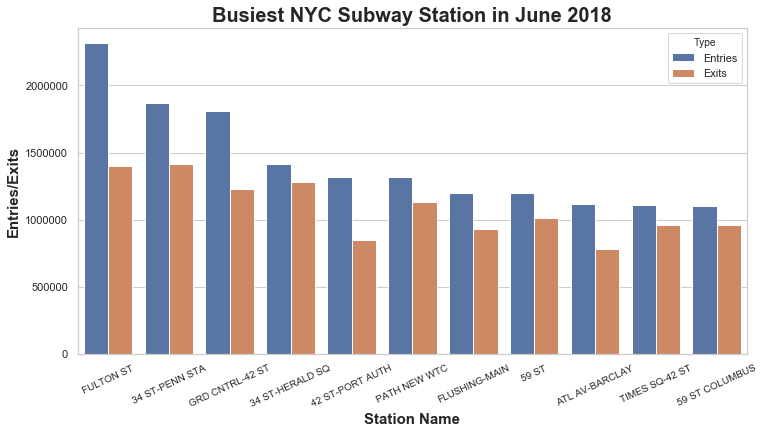

In [34]:
#Plot busiest station in NYC
plt.figure (figsize=(12,6))
sns.set(style = "whitegrid")
sns.barplot(df2['Station'], df2['Count'], hue = df2['Type'])
plt.title("Busiest NYC Subway Station in June 2018", fontsize=20, weight='bold')
plt.xlabel("Station Name", fontsize=15, weight='bold')
plt.ylabel("Entries/Exits", fontsize=15, weight='bold')
plt.xticks(rotation=25, fontsize=10)


In [35]:
#Subsetting data frame by top 10 most quiet
df3 = df_line_stn.drop(columns = ['Linename'])
df3 = df3.tail(11)
df4=pd.melt(df3,id_vars=['Station'],var_name='Type', value_name='Count')
df4

,Station,Type,Count
0,AQUEDUCT N.COND,Entries,26209
1,TOMPKINSVILLE,Entries,23668
2,ROCKAWAY PARK B,Entries,23033
3,BEACH 44 ST,Entries,21799
4,AVENUE I,Entries,18793
5,AVENUE U,Entries,16730
6,BEACH 98 ST,Entries,14015
7,BAY PKWY,Entries,10974
8,BEACH 105 ST,Entries,10553
9,BROAD CHANNEL,Entries,8860


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

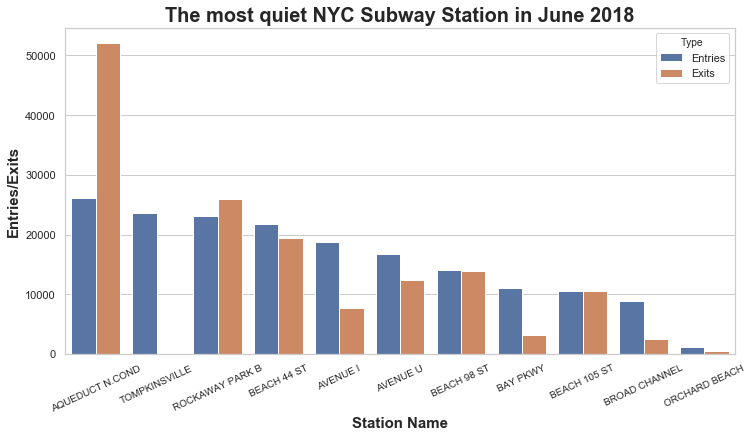

In [36]:
#Plot most quiet place in NYC
plt.figure (figsize=(12,6))
sns.set(style = "whitegrid")
sns.barplot(df4['Station'], df4['Count'], hue = df4['Type'])
plt.title("The most quiet NYC Subway Station in June 2018", fontsize=20, weight='bold')
plt.xlabel("Station Name", fontsize=15, weight='bold')
plt.ylabel("Entries/Exits", fontsize=15, weight='bold')
plt.xticks(rotation=25, fontsize=10)


In [37]:
#NYC Map generation
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=11):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [38]:
#Create dataframe of location for busy station
busy = df1['Station'][:10]
temp_cols = ['Station', 'Lat', 'Lng']
df_busy_loc = df[temp_cols]
df_busy_loc = df_busy_loc[df_busy_loc['Station'].isin(busy)]
df_busy_loc = df_busy_loc.drop_duplicates(keep = 'last').reset_index(drop=True)
df_busy_loc = df_busy_loc.drop([3, 6, 7, 11])
df_busy_loc

,Station,Lat,Lng
0,59 ST,40.64,-74.02
1,42 ST-PORT AUTH,40.76,-73.99
2,34 ST-PENN STA,40.75,-73.99
4,34 ST-HERALD SQ,40.75,-73.99
5,PATH NEW WTC,40.71,-74.01
8,TIMES SQ-42 ST,40.76,-73.99
9,FULTON ST,40.71,-74.01
10,GRD CNTRL-42 ST,40.75,-73.98
12,FLUSHING-MAIN,40.76,-73.83
13,ATL AV-BARCLAY,40.68,-73.98


In [39]:
#Maps markers for busy station
base_map1 = generateBaseMap()
for row in df_busy_loc.iterrows():
    row_values = row[1]
    location = [row_values['Lat'], row_values['Lng']]
    popup = popup ='<strong>' + row_values['Station'] + '</strong>'
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(base_map1)
display(base_map1)

In [40]:
#Create dataframe of location for busy station
quiet = df4['Station'][:10]
df_quiet_loc = df[temp_cols]
df_quiet_loc = df_quiet_loc[df_quiet_loc['Station'].isin(quiet)]
df_quiet_loc = df_quiet_loc.drop_duplicates(keep = 'last').reset_index(drop=True)
df_quiet_loc = df_quiet_loc.drop([0, 1, 2, 3])
df_quiet_loc

,Station,Lat,Lng
4,AQUEDUCT N.COND,40.67,-73.83
5,BROAD CHANNEL,40.61,-73.82
6,BEACH 98 ST,40.59,-73.82
7,BEACH 105 ST,40.58,-73.83
8,ROCKAWAY PARK B,40.58,-73.84
9,BEACH 44 ST,40.59,-73.78
10,AVENUE I,40.63,-73.98
11,BAY PKWY,40.62,-73.98
12,AVENUE U,40.60,-73.97
13,TOMPKINSVILLE,40.64,-74.07


In [41]:
#Maps markers for quiet Station
base_map2 = generateBaseMap()
for row in df_quiet_loc.iterrows():
    row_values = row[1]
    location = [row_values['Lat'], row_values['Lng']]
    popup = popup ='<strong>' + row_values['Station'] + '</strong>'
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(base_map2)
display(base_map2)

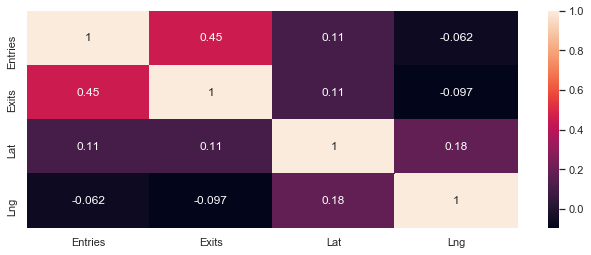

In [42]:
#Correlation between numerical value
plt.figure(figsize=(11,4))
sns.heatmap(df.corr(),annot=True)
plt.show()

## From the chart:
1. The gap between entry and exit is not too big, it has the same patterns between busy and quiet station
2. The busy and quiet station is location based, not only in the business district 
3. The busy and quiet station have a tendency to make a group

## Time Series

In [43]:
#Create time series dataframe
df5 = df_turnstile_cln
df5['Count'] = df5['Entries'] + df5['Exits']
df5 = df5.drop(columns = ['Entries', 'Exits'])
df5

C:\Users\Yoga Pratama S\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,C/A,Unit,SCP,Station,Linename,Date,Count
0,A002,R051,02-00-00,59 ST,456NQRW,2018-05-26,616
1,A002,R051,02-00-00,59 ST,456NQRW,2018-05-27,474
2,A002,R051,02-00-00,59 ST,456NQRW,2018-05-28,593
3,A002,R051,02-00-00,59 ST,456NQRW,2018-05-29,1680
4,A002,R051,02-00-00,59 ST,456NQRW,2018-05-30,1797
...,...,...,...,...,...,...,...
164357,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-25,1490
164358,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-26,1402
164359,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-27,1628
164360,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-28,1291


In [44]:
#Subset for busiest station
df_timeseries = df5.groupby(['Linename', 'Station', 'Date'], as_index=False).sum()
busy = df1['Station']
busy = busy[:5]
df_timeseries = df_timeseries[df_timeseries['Station'].isin(busy)]
df_timeseries

,Linename,Station,Date,Count
1680,123,34 ST-PENN STA,2018-05-26,22623
1681,123,34 ST-PENN STA,2018-05-27,17490
1682,123,34 ST-PENN STA,2018-05-28,19705
1683,123,34 ST-PENN STA,2018-05-29,30835
1684,123,34 ST-PENN STA,2018-05-30,32438
...,...,...,...,...
12563,G,FULTON ST,2018-06-25,8156
12564,G,FULTON ST,2018-06-26,8872
12565,G,FULTON ST,2018-06-27,7521
12566,G,FULTON ST,2018-06-28,6878


Text(0, 0.5, 'Count')

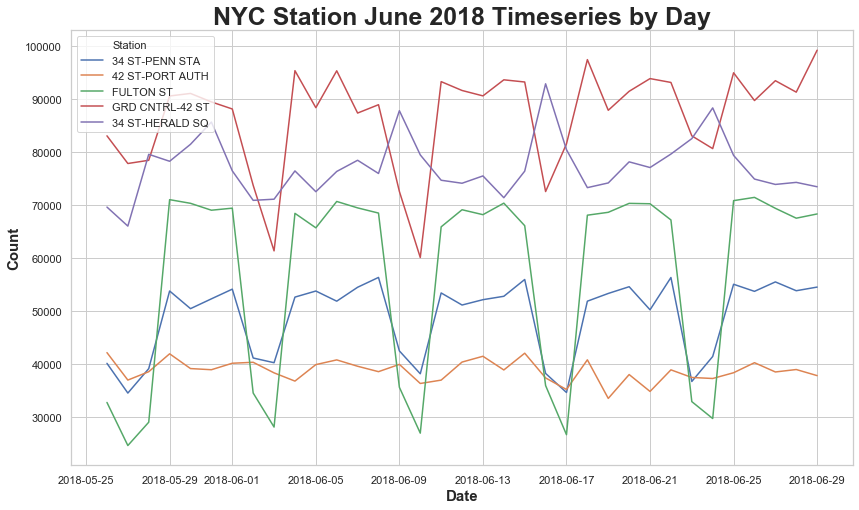

In [45]:
plt.figure(figsize = (14, 8))
ax = sns.lineplot(data=df_timeseries, x="Date", y="Count", hue="Station", ci=None)
ax.set_title('NYC Station June 2018 Timeseries by Day', fontsize=25, weight='bold')
ax.set_xlabel('Date', fontsize=15, weight='bold')
ax.set_ylabel('Count', fontsize=15, weight='bold')


## Timeseries for NYC busiest station by hour

In [242]:
#Subset dataframe by station
df_hour = df_mta[df_mta['STATION'].isin(busy)]
df_hour.reset_index(inplace=True)
df_hour

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2940,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,00:00:00,REGULAR,25275380,10284245
1,2941,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,04:00:00,REGULAR,25275581,10284290
2,2942,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,08:00:00,REGULAR,25275629,10284394
3,2943,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,12:00:00,REGULAR,25275907,10284856
4,2944,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,16:00:00,REGULAR,25276666,10285662
...,...,...,...,...,...,...,...,...,...,...,...,...
76426,153067,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,06/29/2018,05:00:00,REGULAR,333568,13029
76427,153068,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,06/29/2018,09:00:00,REGULAR,333615,13030
76428,153069,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,06/29/2018,13:00:00,REGULAR,333659,13035
76429,153070,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,06/29/2018,17:00:00,REGULAR,333916,13042


In [243]:
#Prepare time series data frame
#Create hourly entry column
hour_entries = df_hour.ENTRIES - df_hour.ENTRIES.shift(1)
df_hour['hour_entries'] = hour_entries.fillna(0)

#Create hourly exits column
hour_exits = df_hour.iloc[ : , 11] - df_hour.iloc[ : , 11].shift(1)
df_hour['hour_exits'] = hour_exits.fillna(0)

df_hour['Total'] = df_hour['hour_entries'] + df_hour['hour_exits']

df_hour = df_hour.drop(columns = ['index'])
df_hour.head(10)

C:\Users\Yoga Pratama S\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Yoga Pratama S\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yoga Pratama S\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,hour_entries,hour_exits,Total
0,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,00:00:00,REGULAR,25275380,10284245,0.00,0.00,0.00
1,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,04:00:00,REGULAR,25275581,10284290,201.00,45.00,246.00
2,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,08:00:00,REGULAR,25275629,10284394,48.00,104.00,152.00
3,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,12:00:00,REGULAR,25275907,10284856,278.00,462.00,740.00
4,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,16:00:00,REGULAR,25276666,10285662,759.00,806.00,1565.00
5,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,20:00:00,REGULAR,25277661,10286270,995.00,608.00,1603.00
6,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2018,00:00:00,REGULAR,25278332,10286579,671.00,309.00,980.00
7,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2018,04:00:00,REGULAR,25278476,10286633,144.00,54.00,198.00
8,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2018,08:00:00,REGULAR,25278506,10286687,30.00,54.00,84.00
9,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2018,12:00:00,REGULAR,25278688,10287007,182.00,320.00,502.00


In [244]:
#CLean outlier using IQR methods
Q1 = df_hour.quantile(0.25)
Q3 = df_hour.quantile(0.75)
IQR = Q3 - Q1
lower_range = Q1 - (1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)

#Using IQR method to clean the data frame
#Check the cleaned dataframe
df_hour_cln = df_hour[~((df_hour < (Q1 - 1.5 * IQR)) |(df_hour > (Q3 + 1.5 * IQR))).any(axis=1)]

In [246]:
#Create datetime column
df_hour_cln['datetime'] = df_hour_cln['DATE'] + " " + df_hour_cln['TIME']
df_hour_cln['datetime'] = pd.to_datetime(df_hour_cln.loc[:, 'datetime'], format='%m/%d/%Y %H:%M:%S')
df_hour_cln.head(10)

C:\Users\Yoga Pratama S\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Yoga Pratama S\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,hour_entries,hour_exits,Total,datetime
85,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,04:00:00,REGULAR,13306664,5201103,118.00,34.00,152.00,2018-05-26 04:00:00
86,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,08:00:00,REGULAR,13306695,5201154,31.00,51.00,82.00,2018-05-26 08:00:00
87,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,12:00:00,REGULAR,13306959,5201443,264.00,289.00,553.00,2018-05-26 12:00:00
88,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2018,16:00:00,REGULAR,13307787,5201880,828.00,437.00,1265.00,2018-05-26 16:00:00
90,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2018,00:00:00,REGULAR,13309228,5202354,534.00,155.00,689.00,2018-05-27 00:00:00
91,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2018,04:00:00,REGULAR,13309319,5202393,91.00,39.00,130.00,2018-05-27 04:00:00
92,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2018,08:00:00,REGULAR,13309341,5202424,22.00,31.00,53.00,2018-05-27 08:00:00
93,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2018,12:00:00,REGULAR,13309471,5202603,130.00,179.00,309.00,2018-05-27 12:00:00
94,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2018,16:00:00,REGULAR,13309949,5202993,478.00,390.00,868.00,2018-05-27 16:00:00
95,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,BMT,05/27/2018,20:00:00,REGULAR,13310709,5203353,760.00,360.00,1120.00,2018-05-27 20:00:00


In [251]:
df_hourly = df_hour_cln[['STATION', 'Total', 'DATE', 'datetime']]
subset_date = ["06/02/2018", "06/03/2018", "06/04/2018", "06/05/2018"]
df_hourly = df_hourly[df_hourly['DATE'].isin(subset_date)]

(array([736847. , 736847.5, 736848. , 736848.5, 736849. , 736849.5,
        736850. , 736850.5, 736851. ]), <a list of 9 Text xticklabel objects>)

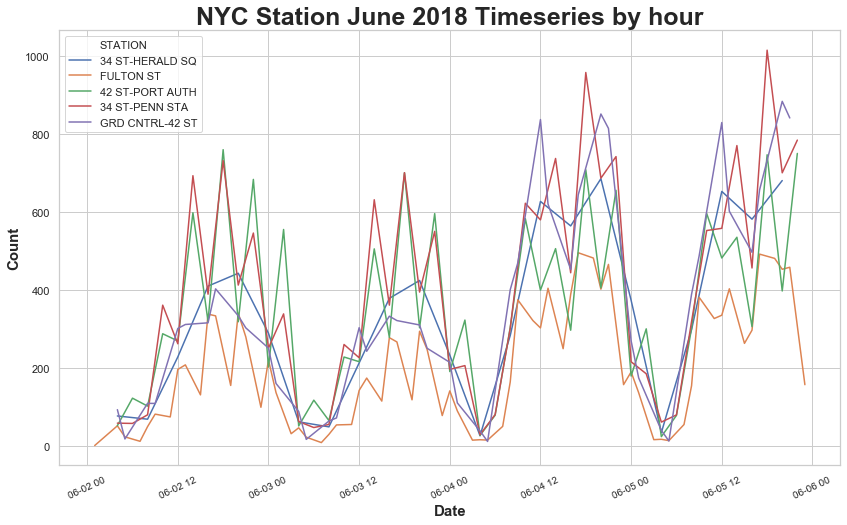

In [253]:
#Visualisation
plt.figure(figsize = (14, 8))
ax2 = sns.lineplot(data=df_hourly, x="datetime", y="Total", hue="STATION", ci=None)
ax2.set_title('NYC Station June 2018 Timeseries by hour', fontsize=25, weight='bold')
ax2.set_xlabel('Date', fontsize=15, weight='bold')
ax2.set_ylabel('Count', fontsize=15, weight='bold')
plt.xticks(rotation=25, fontsize=10)

## From the graph:
1. Subway station is decreasing over the weekend, and will be busy again on the weekday
2. Anomaly on 34 ST-Herald SQ station (this station is in business area)
3. The peak of every cycle is the same for each week (regular customers)

## Exploring using Heatmap and TimeSlider

In [46]:
#Explore with visualization using HeatMap
from folium.plugins import HeatMap
base_map = generateBaseMap()
HeatMap (data=df[['Lat', 'Lng', 'Entries']].groupby(['Lat', 'Lng']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

In [47]:
base_map

In [48]:
df_day_list = []
for day in df.Date.sort_values().unique():
    df_day_list.append(df.loc[df.Date == day, ['Lat', 'Lng', 'Entries']].groupby(['Lat', 'Lng']).sum().reset_index().values.tolist())

In [49]:
#Heatmap with day time entry
from folium.plugins import HeatMapWithTime
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_day_list, radius=20, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

## From the Heatmap:
1. Business area is always crowded compare to the other area
2. North side of the city is bussier compare to south area

# Relationship for predicting the crime

1. Does the crowd size of an area (represented by stations) affect the crime rate?
2. Whether lot of crime happened at the stations/near the stations?
3. What time does the crime usually happened (can connect to crowd size in the station)